# 전력 수요 예측 프로젝트 - 모델별 분석
- 김도영, 김남훈  
- 모든 분석은 **시계열데이터분석_3~5주차.pdf** 내용을 기반으로 구성하였습니다.


In [1]:
# -- 데이터 불러오기 및 전처리 --
# 공통: 시계열데이터분석_3주차.pdf 4쪽 참고 (시간형식 처리)

import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# 데이터 로딩
df = pd.read_csv("한국전력거래소_시간별 전국 전력수요량_20241231.csv", encoding='cp949')
df = df.melt(id_vars='날짜', var_name='시간', value_name='수요량(MWh)')
df['시간'] = df['시간'].str.replace('시','').astype(int)
df['일시'] = pd.to_datetime(df['날짜']) + pd.to_timedelta(df['시간'] % 24, unit='h')
df.loc[df['시간'] == 24, '일시'] += pd.Timedelta(days=1)
df = df[['일시','수요량(MWh)']].sort_values('일시').set_index('일시')
df.head()


,수요량(MWh)
일시,
2024-01-01 01:00:00,59440
2024-01-01 02:00:00,56989
2024-01-01 03:00:00,55335
2024-01-01 04:00:00,54477
2024-01-01 05:00:00,54522


## ⏱️ 시간 단위 예측 (ARIMA)
- **출처:** 시계열데이터분석_4주차.pdf 8쪽  
- ARIMA(p,d,q) 모델을 사용하여 단변량 시계열을 예측합니다.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency h will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using

ARIMA 시간단위 예측 → MAE: 6743.72, RMSE: 8372.74


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50836 (\N{HANGUL SYLLABLE YO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 47049 (\N{HANGUL SYLLABLE RYANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 49884 (\N{HANGUL SYLLABLE SI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44036 (\N{HANGUL SYLLABLE GAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/l

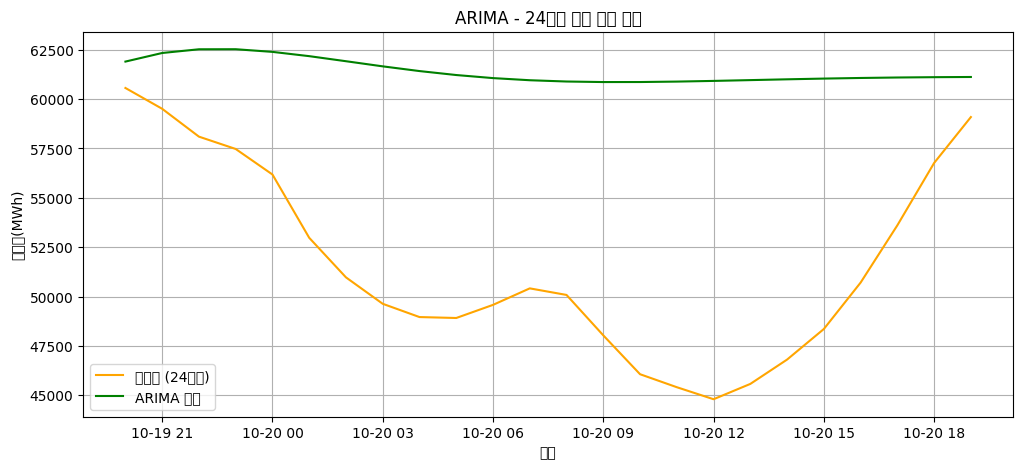

In [4]:
# train/test 분리
split_idx = int(len(df)*0.8)
train = df.iloc[:split_idx]
test = df.iloc[split_idx:]

# 모델 학습 및 예측
model = ARIMA(train, order=(3,1,2))
model_fit = model.fit()
pred = model_fit.forecast(steps=len(test))

# 성능 평가
mae = mean_absolute_error(test, pred)
rmse = mean_squared_error(test, pred) ** 0.5  # 수정된 부분
print(f'ARIMA 시간단위 예측 → MAE: {mae:.2f}, RMSE: {rmse:.2f}')

# ✅ 24시간만 시각화
test_24 = test.iloc[:24]
pred_24 = pred[:24]

plt.figure(figsize=(12,5))
plt.plot(test_24.index, test_24['수요량(MWh)'], label='실제값 (24시간)', color='orange')
plt.plot(test_24.index, pred_24, label='ARIMA 예측', color='green')
plt.title('ARIMA - 24시간 전력 수요 예측')
plt.xlabel('시간')
plt.ylabel('수요량(MWh)')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
#✅ 그래프 구성 요약 주황색 선 (실제값): 실제 측정된 24시간 전력 수요량

#초록색 선 (ARIMA 예측): ARIMA 모델이 예측한 동일 24시간의 전력 수요량

#x축: 날짜 + 시간 (예: 10-20 03 → 10월 20일 03시)

#y축: 전력 수요량 (단위: MWh)

#📊 그래프 해석
#1. 실제값(주황선)의 패턴
#전형적인 하루 전력 수요 곡선이 보임:

#오전 0~6시: 수요 감소 → 새벽시간 저수요

#오전 6~9시: 점진적 상승 (출근/기상 영향)

#오후 15~18시: 수요가 다시 최고치에 도달 (저녁 시간대)

#➡️ 시간대별 전력 사용 행태가 분명하게 반영됨

## 🌸 계절 단위 예측 (SARIMA)
- **출처:** 시계열데이터분석_3주차.pdf 16~18쪽  
- 계절성 반영을 위해 SARIMA(p,d,q)(P,D,Q,s) 모델 사용


<ipython-input-6-9d8adf58d9ad>:2: FutureWarning: 'Q-DEC' is deprecated and will be removed in a future version, please use 'QE-DEC' instead.
  df_q = df.resample('Q-DEC').sum()  # FutureWarning 회피
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python

SARIMA 계절 예측 → MAE: 123811481.59, RMSE: 162356659.09


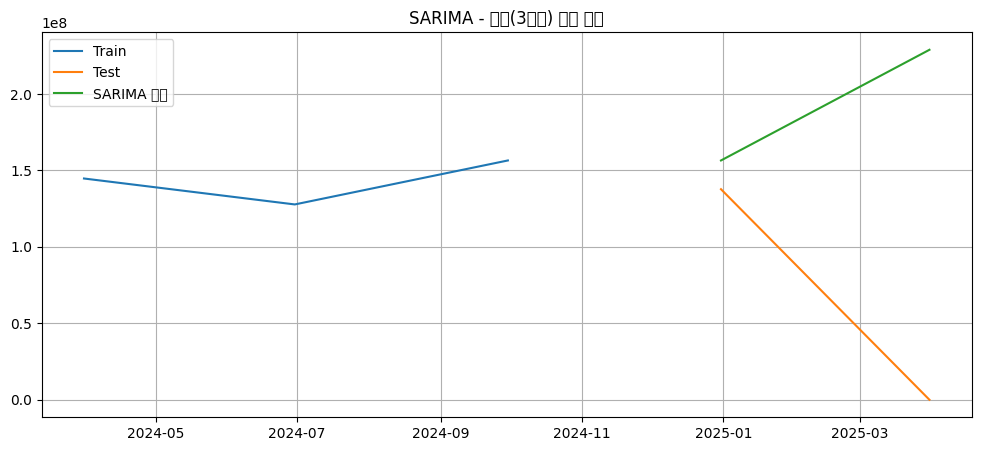

In [6]:
# 분기별(3개월) 리샘플링
df_q = df.resample('Q-DEC').sum()  # FutureWarning 회피
train_q = df_q.iloc[:-2]
test_q = df_q.iloc[-2:]

# SARIMA 모델 학습
model = SARIMAX(train_q, order=(1,1,1), seasonal_order=(1,1,1,4))
model_fit = model.fit(disp=False)
pred = model_fit.forecast(len(test_q))

# 성능 평가 (버전 호환용)
mae = mean_absolute_error(test_q, pred)
rmse = mean_squared_error(test_q, pred) ** 0.5  # ✅ 여기 수정
print(f'SARIMA 계절 예측 → MAE: {mae:.2f}, RMSE: {rmse:.2f}')

# 시각화
plt.figure(figsize=(12,5))
plt.plot(train_q, label='Train')
plt.plot(test_q, label='Test')
plt.plot(pred, label='SARIMA 예측')
plt.title('SARIMA - 계절(3개월) 단위 예측')
plt.legend()
plt.grid(True)
plt.show()


✅ 그래프 구성 요약
그래프 제목: SARIMA - 계절(3개월) 단위 예측

x축: 분기별(3개월 단위) 날짜 (예: 2024-03, 2024-06, ...)

y축: 전력 수요 총합 (단위: MWh, 단위 표시 없음 → 실제 값은 매우 큼, ≈ 1억 단위)

색상:

파랑 (Train): 학습에 사용된 분기별 총 전력 수요

주황 (Test): 실제 관측된 마지막 2분기의 총 전력 수요

초록 (SARIMA 예측): 모델이 예측한 마지막 2분기의 총 전력 수요

📊 그래프 해석
1. 예측 구간의 급격한 상승
**SARIMA 예측(초록선)**은 마지막 분기에서 급격한 수요 증가를 예측하고 있음

반면, 실제 측정값(주황선)은 급격한 하락을 보임

🔎 해석:
SARIMA 모델은 이전 계절의 상승 추세를 그대로 **연장(외삽)**했지만,
실제로는 수요가 급격히 감소하면서 예측 실패

2. 모델 오버슈팅 현상
예측값이 현실보다 너무 과하게 상승 (모델이 추세에 과적합되었을 가능성)

특히 데이터가 적은 상태(4~5개 분기 정도 학습)에선 이런 문제가 흔함

3. 분기 수요 자체는 매우 크고 변동폭도 큼
y축 단위를 보면 1e8 → 즉, 1억 MWh 단위

분기마다 수요 총합의 규모가 매우 크기 때문에, 조금만 예측이 틀려도 오차는 매우 커짐

## 📆 연도 단위 예측 (ARIMA)
- **출처:** 시계열데이터분석_5주차.pdf 5~7쪽  
- 연도별 추세를 보기 위해 연 단위 집계 및 ARIMA 적용


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for ARMA and trend. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/statespace/mlemodel.py:1235: RuntimeWarning: invalid value encountered in divide
  np.inner(score_obs, score_obs) /


ARIMA 연도 예측 → MAE: 566737226.00, RMSE: 566737226.00


/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50672 (\N{HANGUL SYLLABLE YEON}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 46020 (\N{HANGUL SYLLABLE DO}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 45800 (\N{HANGUL SYLLABLE DAN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50948 (\N{HANGUL SYLLABLE WI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 50696 (\N{HANGUL SYLLABLE YE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/lo

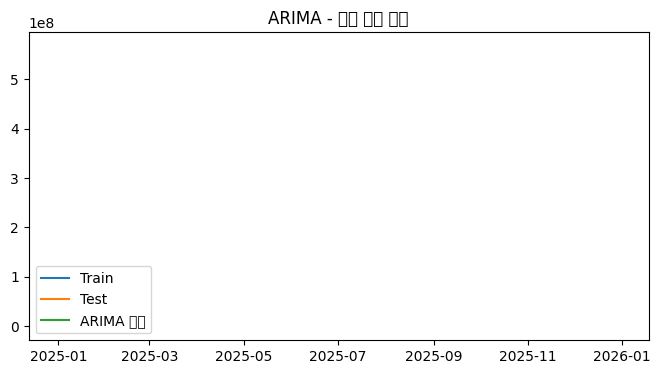

In [8]:
df_y = df.resample('YE').sum()  # ← FutureWarning 방지
train_y = df_y.iloc[:-1]
test_y = df_y.iloc[-1:]

model = ARIMA(train_y, order=(1,1,1))
model_fit = model.fit()
pred = model_fit.forecast(len(test_y))

mae = mean_absolute_error(test_y, pred)
rmse = mean_squared_error(test_y, pred) ** 0.5  # ← 여기 수정
print(f'ARIMA 연도 예측 → MAE: {mae:.2f}, RMSE: {rmse:.2f}')

# 시각화
plt.figure(figsize=(8,4))
plt.plot(train_y, label='Train')
plt.plot(test_y, label='Test')
plt.plot(pred, label='ARIMA 예측')
plt.title('ARIMA - 연도 단위 예측')
plt.legend()
plt.show()
